In [1]:
%matplotlib inline

# Main
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Models
from keras.applications.mobilenet import MobileNet, decode_predictions
from keras.applications.mobilenet import preprocess_input as preprocess_input_MN

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_dns

# Layers and utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, MaxPool2D, Conv2D, \
                                    Flatten, Rescaling, Resizing, GlobalAveragePooling2D,\
                                    BatchNormalization, Activation, SeparableConv2D,\
                                    RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Visualization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots
import seaborn as sns
import cv2
import matplotlib.cm as plt_cm
from PIL import Image
from IPython.display import display
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from tensorflow.keras.preprocessing import image as tf_image
from skimage.segmentation import mark_boundaries

# Python native libiraries
from collections import Counter
import os
import pickle
import datetime

# Set seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)

BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

def fast_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

2024-02-09 08:26:29.088898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 08:26:29.088986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 08:26:29.369871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 08:26:30.131564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 08:26:34.340128: W tensorflow/compiler/tf2

# Using transferlearning for medical image classification. Pros, cons and a discussion.
## Problem definition:
VERY IMPORTANT FOR THE PROJECT TO READ > [LINK](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

Create a robust model for classifying pneumonia using x-ray images and compare it to other models that professionals have made. Discuss the model's application and capacity.

## Results:
TL;DR -- it works, but it could be better.

Even though, as we will see, training a model on detecting only pneumonia is easy considering the available models that can be used for transfer learning, but creating a model that understands different medical chest area conditions is *hard* and studies (which will be referenced) show that we can do better.

A success was the attempt of creating a model (`ResNet151V2_GRADCAM_BALANCED`) that achieves 0.92 test accuracy as well as val accuracy of 0.95.

I have tried to the best of my abilities to describe my process, where are my faults, what other people have done and how a  more general model for such a task can be built.

## Data, literature and sources:
The main dataset is the [UCSD's Chest X-Ray Images for Classification dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2) which is used for the training of the models.

#### Why x-ray images?
X-ray images strike a balance between:
1. Descriptive capacity - because x-ray imaging is based electromagnetic exposure in the range of $3\times 10^{16}$ Hz to $3\times 10^{19}$ Hz with energies between 100eV and 100keV ([source](https://en.wikipedia.org/wiki/X-ray)), we can produce a non-invasive way to examine a patient. Because of the nature of the x-rays, liquid in the lungs, swelling and other types of medical conditions can be seen as white spots on the images. X-ray images can also show specific patterns for different conditions, i.e. viral pneumonia looks different from bacterial pneumonia.

2. Affordability - the x-ray technology has been available to us for more than a hundred years and it has undergone many advances and wide spread adoption.

3. Speed - taking an x-ray picture takes about 5 minutes and it doesn't need to be developed in a dark room like classic film photography. If a doctor (radiologist) is at hand, a diagnosis can be quickly made. 

The cons of x-ray images is that they are 2D, have limited detail and it exposes patients to radiation (even though in small doses). In the real world there's also not guarantee that a clinical professional will be on site to give diagnoses - this is most true for 3rd world countries and even here in Bulgaria where the waiting time for a diagnosis is minimum 5 hours, personally experienced.

Other methods like MRI and CT scans solve the mentioned problems (like producing a 3D image) but they remain relatively more expensive than x-ray imaging.

#### Research
Research such as [Pranav Rajpurkar and Andrew Ng's](https://arxiv.org/pdf/1711.05225.pdf) paper on CheXNet, [Ankita Shelke and Ninad Mehendale's](https://pubmed.ncbi.nlm.nih.gov/34075355/) paper on Automated COVID-19 Screening and the [NIH-Chest-X-rays-Classification](https://github.com/paloukari/NIH-Chest-X-rays-Classification?tab=readme-ov-file#Conclusion) project by Spyros Garyfallos, Brent Biseda, and Mumin Khan were used as main sources. My results and observations will be cross-validated with those mentioned works.

[Understanding Deep Learning by Simon J.D. Prince](https://github.com/udlbook/udlbook) was also used as a reference.

#### Data
Data for this work is linked [here](https://www.kaggle.com/datasets/momchilgeorgiev/crx8-subsamples). And it should be put in `./data` like this:

<img src="./images/tree1.JPG" style="height:300px" />

I have trained two models in kaggle, which are accessible to download [here](https://huggingface.co/MGeorgieff/ResNet151V2_GRADCAM/tree/main)

There should be put in these directories:

<img src="./images/tree2.png" style="height:150px" />

I have also provided logs for one of the models. I had issues saving tensorbaord logs since I lost some of them while playing in kaggle which is my fault for not using ml flow and backing up my data. As one can see, a MoE is mentioned, we will get to that in a bit.

<img src="./images/logs.png" style="height:150px" />

Article summaries can be found in `./research_papers`

<img src="./images/123321.png" style="height:500px" />

Notebooks `TELL_RESEARCH_PAPER.ipynb` and `Mixtral_of_experts.ipynb` contain the article summaries.

## Workflow

#### Setup
The custom models have been trained locally on my PC (16gb RAM, GTX1080 with 6.1 compute compatability). The models using transfer learning have been trained on kaggle since there I had access to P100 GPU (16 VRAM) and higher RAM capacity (30gb). [This](https://www.kaggle.com/code/momchilgeorgiev/20203dl-prj-notebook/notebook?scriptVersionId=162224076) is my kaggle notebook, it also acts as a "draft paper", meaning most of the first code was written there. My repo for this project is [here](https://github.com/momchilgeorgiev/2023DL) but is in poor condition since I *transferred* my work in kaggle. The models, as mentioned, can be found in [my hugging face repo](https://huggingface.co/MGeorgieff/ResNet151V2_GRADCAM/tree/main).

When building a model first I create a really simple one and build from there. The same protocol is used when trying to solve the problem at hand. First I will start with a simple scenario, classifying if one person has pneumonia and then I will try to create a model that classifies different medical conditions in the chest area.

##### Models
The models I have trained (`ResNet151V2_GRADCAM` and `ResNet151V2_GRADCAM_BALANCED`) are two variations of the same model but trained with unbalanced and balanced data, of which one can guess that the second is more stable. 

I have also tried to create a MoE for classifying the [NIH Chest X-Ray dataset](https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345) and but it resulted in failure. More information about that and the motive behind it can be found in section 4.

##### Reproducibility
I have set `tf.random.set_seed(SEED)` with `SEED = 42`. 

When splitting data a seed of 42 is also used to ensure that when loading the models locally and testing them the test and validation samples are the same with those used in kaggle while training and evaluating to avoid data leakage.

## Project structure:
1. Data augemntation and pipelining;
2. CNN model for pneumonia classification;
3. Applied transfer learning for x-ray image classification;
4. Discussion
5. Sources


I will begin the project explaining why simple and even some deep neural architectures do not work on the task at hand. Then I will focus the attention at transfer learning.


### 1. Data augmentaion and pipelining

For a dataset we will
 use the UCSD's since as a rule of thumb it is good to start with a simple task and start building from there. This means that first we will classify only pneumonia. I have made everything available in [kaggle](https://www.kaggle.com/datasets/momchilgeorgiev/crx8-subsamples) and I will download my data from there.

I am loading them using `tf.keras.utils.image_dataset_from_directory()` and doing image augmentations when building the NN.

In [2]:
# ! kaggle datasets download -d momchilgeorgiev/crx8-subsamples # Download directly the data from kaggle

In [2]:
TRAIN_PATH = '../data/chest_xray/train'
TEST_PATH = '../data/chest_xray/test'

This train test split function takes the directories of the images and passes them to `tf.keras.utils.image_dataset_from_directory()`. Other arguments include the batch size of the dataset, colour map, the shape of the images, AUTOTUNE for the caching and prefetching as well as option to get a smaller subset of the whole dataset. 

As mentioned, a seed of 42 has been picked for consistency when splitting the data for evaluating models on different instances.

In [3]:
def tts(train_path, test_path, subset = False, subset_split = None, BATCH_SIZE = 16, AUTO = tf.data.experimental.AUTOTUNE, color_mode = 'rgb', img_shape = (224, 224)):
  train = tf.keras.utils.image_dataset_from_directory(train_path,
                                                    subset = 'training',
                                                    validation_split = 0.1,
                                                    image_size = img_shape,
                                                    shuffle = True,
                                                    batch_size = BATCH_SIZE,
                                                    seed = 42,
                                                    color_mode = color_mode
                                                    )
  val = tf.keras.utils.image_dataset_from_directory(train_path,
                                                      subset = 'validation',
                                                      validation_split = 0.1,
                                                      image_size = img_shape,
                                                      shuffle = True,
                                                      batch_size = BATCH_SIZE,
                                                      seed = 42,
                                                      color_mode = color_mode
                                                      )
  test = tf.keras.utils.image_dataset_from_directory(test_path,
                                                      image_size = img_shape,
                                                      shuffle = True,
                                                      batch_size = BATCH_SIZE,
                                                      seed = 42,
                                                      color_mode = color_mode
                                                      )

  cls_names = train.class_names

  if subset:
    subset_ratio = subset_split
    subset_val_test = int(subset_ratio * 0.2)
    print('Subset is loaded!')
    train_subset = train.take(subset_ratio).cache().prefetch(AUTO)
    val_subset = val.take(subset_val_test).cache().prefetch(AUTO)
    test_subset = test.take(subset_val_test).cache().prefetch(AUTO)

    return train_subset, test_subset, val_subset, cls_names
  else:
    print('Full dataset is loaded!')
    train= train.cache().prefetch(AUTO)
    val = val.cache().prefetch(AUTO)
    test = test.cache().prefetch(AUTO)

    return train, test, val, cls_names


### Setting params:

I will first get a subset of 50 samples just to illustrate how a simple model cannot fit properly the data. Think of it as measuring the problem. I believe this step is important, since 1) I want to show my thinking process and 2) to demonstrate that not every problem can be explained by Occam's razor. By this I mean that usually a simple model generalizes better but to a certain extent (tf tutorial which also touches on this subject [here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_weight_regularization)). After that we need to create more complex models that have a higher capacity to learn a larger set of data. My point is that the complexity of classifying x-ray images is high and one cannot even start with a simple model, it immediately has bad results (more on that in the next section) - this fact resulted in a lot of trials and confusions, because basically I was trying first simple architectures (for close to a week) and only after some time, when I saw that nothing comes out of this, I decided to try a relatively big model.

In [4]:
img_shape = (124, 124)
img_h_shape = img_shape[0]
train, test, val, class_names = tts(TRAIN_PATH, TEST_PATH, BATCH_SIZE = 32,
                                    subset = True, subset_split = 50,
                                    img_shape=img_shape,
                                    color_mode = 'grayscale')
                                    

Found 5216 files belonging to 2 classes.
Using 4695 files for training.


2024-02-09 07:49:03.227494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 07:49:03.227596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 07:49:03.227632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 07:49:03.748705: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 07:49:03.748792: I external/local_xla/xla/stream_executor

Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.
Subset is loaded!


Let's see class distributions:

In [5]:
normal_counts = len(os.listdir(TRAIN_PATH + '/NORMAL'))
pneu_counts = len(os.listdir(TRAIN_PATH + '/PNEUMONIA'))
labels = ['NORMAL', 'PNEUMONIA']

Text(0, 0.5, 'Counts')

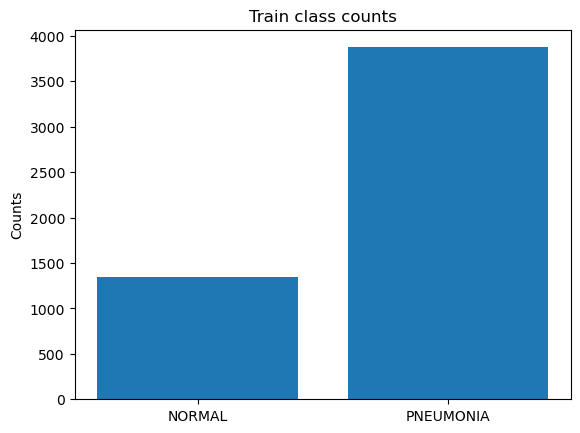

In [6]:
plt.title('Train class counts')
plt.bar(labels, [normal_counts, pneu_counts])
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

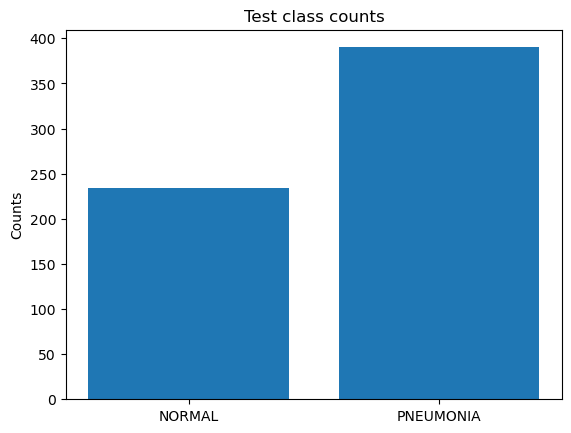

In [7]:
normal_counts = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_counts = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
labels = ['NORMAL', 'PNEUMONIA']
plt.title('Test class counts')
plt.bar(labels, [normal_counts, pneu_counts])
plt.ylabel('Counts')

It is obvious that the classes are imblanced. This will be corrected when we will train our main models.

### 2. CNN model for pneumonia classification

#### Training

Essentially this classification problem looks easy at first, but many people will know that it is not. Creating a shallow CNN won't do the trick here, eventhough my presumtions. I want to demonstrate this and this section will be only as an example. Real training is in section 3!

First we can train a simple model that will work but it falls apart when we try to add augmentations (like rotation and zoom) to recreate some kind of a real world scenario. Here is an example:

In [8]:
normalization_layer = Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))
val = val.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(img_h_shape,
                                  img_h_shape,
                                  1)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

The layers randomly flip, rotate and zoom the image. Here is how it will look like:

In [9]:
def viz_aug(ds, aug_input_layer, plot_size=(8, 6)):
    # Take a single example from the dataset 
    for img, _ in ds.take(1):
        img = tf.expand_dims(img[0], 0)  # Take the first image of the batch
        augmented_img = aug_input_layer(img)  # Apply augmentation
        
        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=plot_size)
        # Squeeze to remove batch dimension for plotting
        axes[0].imshow(tf.squeeze(img).numpy(), cmap='gray')
        axes[0].set_title('Original Image')
        
        axes[1].imshow(tf.squeeze(augmented_img).numpy(), cmap='gray')
        axes[1].set_title('Augmented Image')
        plt.show()

2024-02-09 07:50:00.128651: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


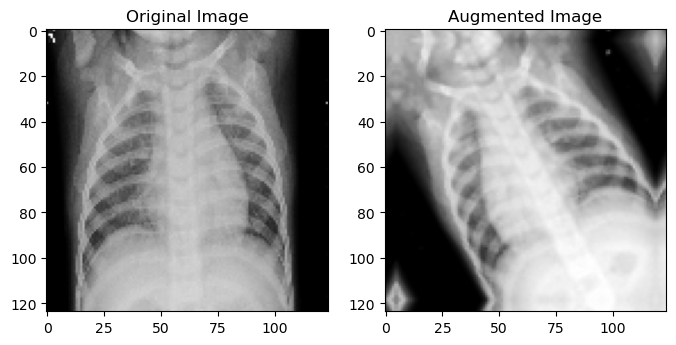

In [11]:
viz_aug(train, data_augmentation)

Now let's create a function to quickly compile and train the model.

LR is small since we are training a CNN.

Callbacks for tensorboard and CheckpointModel are added for data analysis.

Early stopping (`es`) is optional argument which has a patience for 6 epcohs.

`ReduceLROnPlateau()` is called to change the LR when the validation accuracy plateaus.

Adam is chosen for LR optimization because it adapts well to a high dimensional space.

Sparse categorical cross entropy (SCCE or CEE) is our loss function. It fits for out task for classification since it measures the predicted probability distributions and the PD for the ground truth (the true distribution of the classes). The labels are not one-hot encoded and that's why we are going for the sparse variant. I have chosen the multi class version, not the binary type, because the current works for the two cases.

In [12]:
def train_custom_model(custom_model, name = 'Empty', train = None, val = None, LR = 0.0001, EPO = 3, es = False):
  # Early stopping
  earlystopping = EarlyStopping(monitor='val_accuracy', mode='min', patience=6, verbose = 1)

  # Checkpoints
  file_path = "../content/models/" + f"{name}/" + f"{name}" + "{epoch:02d}-{val_loss:.2f}.h5"

  checkpoint_best = ModelCheckpoint(file_path + "based.h5",
                                    monitor='val_accuracy', save_best_only=True, verbose=1)

  # checkpoint_per_epo = ModelCheckpoint(file_path + "epo.h5",
  #                                      monitor='val_accuracy', save_freq = 'epoch',
  #                                      save_best_only=False, verbose=1)
  # Lr scheduler
  dynamicLR = ReduceLROnPlateau(monitor='val_accuracy', patience = 2,
                                verbose=1,factor=0.2, min_lr=LR/1000)

  # Generate a log directory based on hyperparams
  log_dir = "logs/fit/" + f'{name}' + f'_LR{LR}_EPO{EPO}'
  tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

  # Create callback list
  callback_list = [checkpoint_best, dynamicLR, tensorboard_callback]

  # Fit model
  if es:
    callback_list = [checkpoint_best, dynamicLR, tensorboard_callback, earlystopping]
  else:
    callback_list = [checkpoint_best, dynamicLR, tensorboard_callback]
  custom_model.compile(optimizer = Adam(LR), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  history = custom_model.fit(train, validation_data = val, epochs = EPO, callbacks = [callback_list])

  return custom_model, history

Now create the most simplest model ever:

In [13]:
tf.keras.backend.clear_session

<function keras.src.backend.clear_session()>

Create the model (using softmax, because we have I want to have the probability distributions of the two classes):

In [14]:
model = Sequential([
  data_augmentation,
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPool2D(),
 
  
  Flatten(),
  Dense(4, activation='relu'),
 
  Dense(len(class_names), name="outputs", activation = 'softmax')
])

model_name = 'simple_model_v1'
model_out, history_simple_model_v1 = train_custom_model(model, name = model_name, train = train, val = val, LR = 0.1, EPO = 15, es = True)
print('\nTEST')
model_out.evaluate(test)

Epoch 1/15


2024-02-09 07:50:11.478344: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-09 07:50:14.459119: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-09 07:50:15.971826: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa8149f1a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-09 07:50:15.971872: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-02-09 07:50:16.094183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707457816.478034  244535 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - ETA: 0s - loss: 23.1744 - accuracy: 0.7088
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to ../content/models/simple_model_v1/simple_model_v101-0.54.h5based.h5


/home/tf/miniconda3/envs/tf1/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 28s 380ms/step - loss: 23.1744 - accuracy: 0.7088 - val_loss: 0.5416 - val_accuracy: 0.7750 - lr: 0.1000
Epoch 2/15
 3/50 [>.............................] - ETA: 1s - loss: 0.5724 - accuracy: 0.7396

2024-02-09 07:50:36.217229: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59043840 exceeds 10% of free system memory.


50/50 [==============================] - ETA: 0s - loss: 0.5848 - accuracy: 0.7312
Epoch 2: val_accuracy did not improve from 0.77500
50/50 [==============================] - 1s 13ms/step - loss: 0.5848 - accuracy: 0.7312 - val_loss: 0.5353 - val_accuracy: 0.7750 - lr: 0.1000
Epoch 3/15
11/50 [=====>........................] - ETA: 0s - loss: 0.5862 - accuracy: 0.7301

2024-02-09 07:50:36.945351: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59043840 exceeds 10% of free system memory.


50/50 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7312
Epoch 3: val_accuracy did not improve from 0.77500

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.020000000298023225.
50/50 [==============================] - 1s 12ms/step - loss: 0.5856 - accuracy: 0.7312 - val_loss: 0.5342 - val_accuracy: 0.7750 - lr: 0.1000
Epoch 4/15
11/50 [=====>........................] - ETA: 0s - loss: 0.5853 - accuracy: 0.7301

2024-02-09 07:50:37.578282: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59043840 exceeds 10% of free system memory.


46/50 [==========================>...] - ETA: 0s - loss: 0.5886 - accuracy: 0.7262
Epoch 4: val_accuracy did not improve from 0.77500
50/50 [==============================] - 1s 13ms/step - loss: 0.5837 - accuracy: 0.7312 - val_loss: 0.5400 - val_accuracy: 0.7750 - lr: 0.0200
Epoch 5/15
11/50 [=====>........................] - ETA: 0s - loss: 0.5833 - accuracy: 0.7301

2024-02-09 07:50:38.251650: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59043840 exceeds 10% of free system memory.


47/50 [===========================>..] - ETA: 0s - loss: 0.5856 - accuracy: 0.7287
Epoch 5: val_accuracy did not improve from 0.77500

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.003999999910593033.
50/50 [==============================] - 1s 13ms/step - loss: 0.5831 - accuracy: 0.7312 - val_loss: 0.5382 - val_accuracy: 0.7750 - lr: 0.0200
Epoch 6/15
11/50 [=====>........................] - ETA: 0s - loss: 0.5832 - accuracy: 0.7301

2024-02-09 07:50:38.892716: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59043840 exceeds 10% of free system memory.


45/50 [==========================>...] - ETA: 0s - loss: 0.5873 - accuracy: 0.7257
Epoch 6: val_accuracy did not improve from 0.77500
50/50 [==============================] - 1s 12ms/step - loss: 0.5818 - accuracy: 0.7312 - val_loss: 0.5373 - val_accuracy: 0.7750 - lr: 0.0040
Epoch 7/15
48/50 [===========================>..] - ETA: 0s - loss: 0.5826 - accuracy: 0.7305
Epoch 7: val_accuracy did not improve from 0.77500

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.
50/50 [==============================] - 1s 13ms/step - loss: 0.5812 - accuracy: 0.7319 - val_loss: 0.5370 - val_accuracy: 0.7750 - lr: 0.0040
Epoch 7: early stopping

TEST
10/10 [==============================] - 3s 171ms/step - loss: 0.6528 - accuracy: 0.6594


[0.652847409248352, 0.659375011920929]

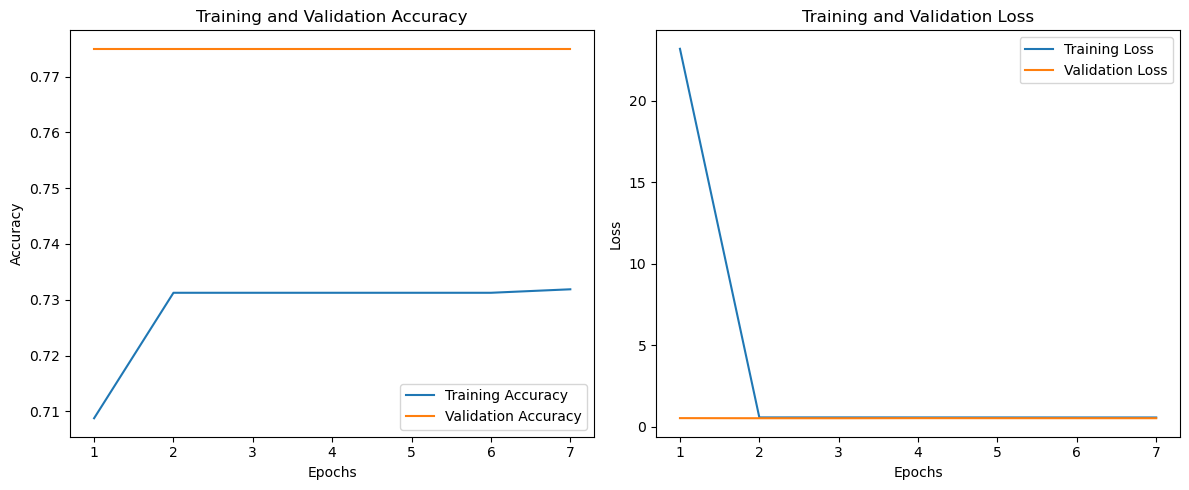

In [15]:
fast_plot(history_simple_model_v1)

The model has high loss values and low accuracy on validation and pretty much nothing on the test set. This tells us that the model cannot generalize very well and it's capacity for understanding the data is pretty low.

Creating a "deeper" model doesn't do much either:

In [16]:
tf.keras.backend.clear_session

<function keras.src.backend.clear_session()>

In [17]:
model = Sequential([
  data_augmentation,
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPool2D(),

  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),

  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPool2D(),
  
  Dropout(0.2),

  Flatten(),
  Dense(64, activation='relu'),
  Dense(len(class_names), name="outputs", activation = 'sigmoid')
])


model_name = 'simple_model_v2'
model_out, history_simple_model_v2 = train_custom_model(model, name = model_name, train = train, val = val, LR = 0.1, EPO = 15, es = True)
print('\nTEST')
model_out.evaluate(test)

Epoch 1/15


2024-02-09 07:50:50.397322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


49/50 [============================>.] - ETA: 0s - loss: 112.1043 - accuracy: 0.6792
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to ../content/models/simple_model_v2/simple_model_v201-0.54.h5based.h5
50/50 [==============================] - 4s 20ms/step - loss: 109.8728 - accuracy: 0.6812 - val_loss: 0.5375 - val_accuracy: 0.7750 - lr: 0.1000
Epoch 2/15
48/50 [===========================>..] - ETA: 0s - loss: 0.5934 - accuracy: 0.7298
Epoch 2: val_accuracy did not improve from 0.77500
50/50 [==============================] - 1s 18ms/step - loss: 0.5918 - accuracy: 0.7312 - val_loss: 0.5350 - val_accuracy: 0.7750 - lr: 0.1000
Epoch 3/15
49/50 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.7302
Epoch 3: val_accuracy did not improve from 0.77500

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.020000000298023225.
50/50 [==============================] - 1s 17ms/step - loss: 0.5904 - accuracy: 0.7312 - val_loss: 0.5342 - val_accuracy: 0

[0.6527689695358276, 0.659375011920929]

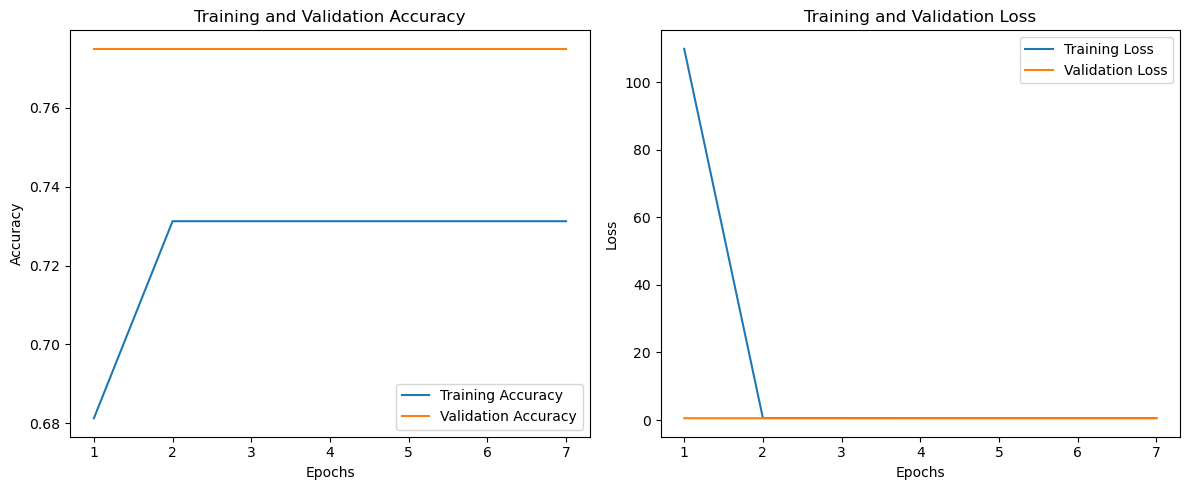

In [18]:
fast_plot(history_simple_model_v2)

Same story again...

*We need to go deeper*. While researching I have found that the best models implement transfer learning. One of the best results on this dataset is the attempt of [Nain](https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution) in kaggle, who had accomplished recall of 0.98 and precision of 0.79 with this architecture and loading the weights of VGG16 seprately (this part is ommited here but you can see it in the original post).

This and other examples I will briefly now mention show that NNs using transfer learning will be more fit for this task.

In his post Nain mentions that the best way to approach this problem is to let only the first `n` layers of the backbone to be frozen and the rest to retrain them. This makes sense since the first layers learn general shapes, edges, light blops and other basic elements of an image.

Taking a look at official research Pranav Rajpurkar and Andrew Ng's **ChexNet** uses a DenseNet architecture. The NIH-Chest-X-rays-Classification by Spyros Garyfallos, Brent Biseda actually compare same model but with **different backbones** (Mobilenet, ResNet and VGG) resulting in 3 custom models with the mentioned backbones and one ensemble model with 3 variations. Ankita Shelke and Ninad Mehendale also use **VGG** (VGG16) and then pass the classified images (the models are not connected, the images are simply passed on to the other models) to **DenseNet161** for COVID classification.

This information prompted me to focus my effort on building a **CNN** model with transferlearning, unfreezing most of the base model's layers so to overcome high bias. In both P. Rajpurkar and A. Ng's paper and S. Garyfallos, B. Biseda, and M. Khan's work we can see the VGG16 performs the *worst* out of everything else, but in Nain's case it works well. In any case I have decided do forgo VGG16 as an option since these and many other research papers show that it doesn't do as well as other models for this task specifically.

### 3. Applied transfer learning for x-ray image classification

#### Training ResNet151v2 on UCSD X-ray Data

The model I went for is ResNet151V2, which during evaluation gave the "best" results. I have trained the model in kaggle and [here](https://www.kaggle.com/code/momchilgeorgiev/20203dl-prj-notebook/notebook?scriptVersionId=162224076) is a direct link to the notebook. I will give the code used to train it here and explain it. But if one wants to run it I advice to do it in kaggle.

#### Training overview

There are a few differences with the training compared to the other models. First I have chosen to use cosine learning rate scheduler (defined in `get_cosine_decay()`) since we are training a deep NN and cosine decay let's us get out of local minimums during GD by drasticly increasing the LR for a short time and then decreasing it slowly. This also means that `ReduceLROnPlateau()` has been left out during training.

First ResNet151V2 needs 3 channels. Image size is set as such to comply with the input requirments of the basemodel. The model is also trained on the whole dataset.

`preprocess_data()` handles the `preprocess_input()` that every backbone in TF comes with and the function is mapped to the train, test and val data. 

Now here we do tts:

In [19]:
img_shape = (224, 224)
IMG_SIZE = 224
img_h_shape = img_shape[0]
train, test, val, class_names = tts(TRAIN_PATH, TEST_PATH, BATCH_SIZE = 32,
                                    subset = False, subset_split = 50,
                                    img_shape=img_shape,
                                    color_mode = 'rgb')

def preprocess_data(img, label):
    return tf.keras.applications.resnet_v2.preprocess_input(img), label

train = train.map(preprocess_data).cache().prefetch(AUTO)
validation = val.map(preprocess_data).cache().prefetch(AUTO)
test = test.map(preprocess_data).cache().prefetch(AUTO)
print('Images scaled!')

Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.
Full dataset is loaded!
Images scaled!


Here we set up the cosine scheduler. The function has a useful plot that shows us how the LR values will look like during training!

In [20]:
def get_cosine_decay(ds, epochs = 1, learning_rate = None, quick_plot = False):
    num_batches = tf.data.experimental.cardinality(ds).numpy()
    decay_steps = epochs * num_batches  

    cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
                    initial_learning_rate = learning_rate,
                    decay_steps = decay_steps
                    )

    # This is really stupid but yet handy
    if quick_plot:
        # Generate a range of step values
        steps = np.linspace(0, decay_steps, num=EPO * num_batches)

        # Compute the learning rate for each step
        learning_rates = cosine_decay(steps)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(steps, learning_rates)
        plt.title('Cosine Decay Learning Rate Schedule')
        plt.xlabel('Steps')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.show()

    return cosine_decay

LR and EPO have these values because we use them below for training.

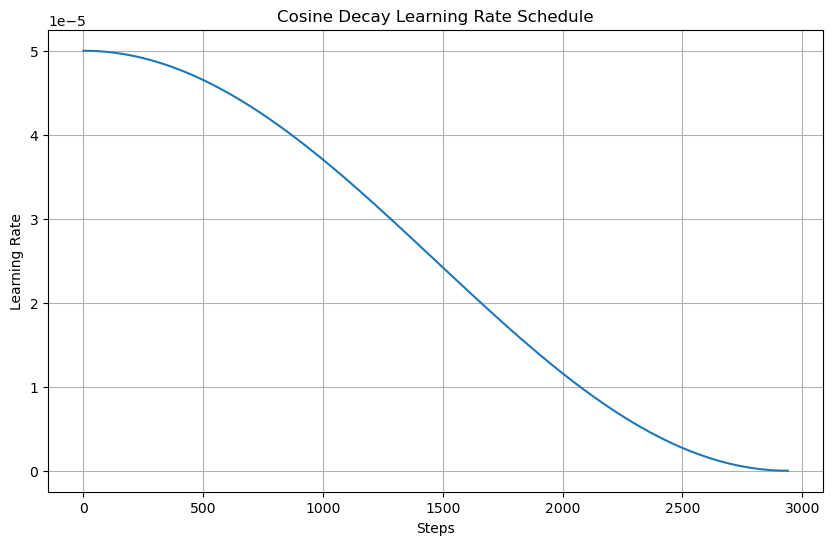

In [21]:
LR = 5e-5
EPO = 20
get_cosine_decay(train, epochs = EPO, learning_rate = LR, quick_plot = True)

`train_custom_model()` has already been explained as well as its differences here.

In [22]:
def train_custom_model(custom_model, name = 'Empty', train = None, val = None, LR = 0.0001, EPO = 3, es = False):    

    file_path = "../content/models/" + f"{name}/" + f"{name}" + '{epoch:02d}-{val_loss:.2f}.h5'
    checkpoint = ModelCheckpoint(file_path, monitor = 'val_accuracy', save_best_only=True, verbose=1)

    # Generate a log directory based on hyperparams
    log_dir = "logs/fit/" + f'{name}' + f'_LR{LR}'
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    cosine_delay_schedule = get_cosine_decay(train, epochs = EPO, learning_rate = LR)

    # Fit model
    if es:
        earlystopping = EarlyStopping(monitor ='val_accuracy', patience = 3, verbose = 1)
        callback_list = [checkpoint, tensorboard_callback, earlystopping]
    else:
        callback_list = [checkpoint, tensorboard_callback]
        
    custom_model.compile(optimizer = Adam(learning_rate = cosine_delay_schedule), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    history = custom_model.fit(train, validation_data = val, epochs = EPO, callbacks = [callback_list])

    return custom_model, history

In [23]:
# Define the input layer
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Define data augmentation layers
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)

# Load the ResNet152V2 base model without the top layer
base_model = tf.keras.applications.ResNet152V2(include_top=False, input_tensor=x, weights='imagenet')

# Set the base model's layers to non-trainable, except the last 13
base_model.trainable = True
for layer in base_model.layers[:-13]:
    layer.trainable = False

# Continue building your model
# Use the base_model's output as input to the next layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation='softmax')(x)  # Assuming binary classification

# Create the new model
model = Model(inputs=inputs, outputs=outputs)

And here we compile and fit the model:

In [ ]:
# model_name = 'Add name here'
# model_pretrained = model
# model_out, history_resnet151v2_v3 = train_custom_model(model_pretrained, name = model_name, train = train, val = validation, LR = 5e-5, EPO = 20, es = True)
# print('\nTEST')
# model_out.evaluate(test)

During training the best model achieved validation accuracy of 0.9846 and test accuracy of 0.8654. Let's load the best checkpoint and reproduce testing. I am using `.keras` extension because during training one problem came up with `.h5` - model does **worse** on the same test set when being loaded (specifically, when downloading the model from kaggle and loading it here locally). The reason is because TF doesn't load the model with the right parameters and you have to recompile it manually, which is pretty annoying keeping in mind that you have to copy the initial training params from kaggle to the personal notebook. `.keras` doesn't require this but it takes longer to load. I have provided the code for recompiling but it is not needed, it's here just in case!

In [3]:
# Run ResNet151V2_v1_GRADCAM_UNBALACED.keras
resnet = tf.keras.saving.load_model('../content/models/ResNet151V2_GRADCAM/ResNet151V2_v1_GRADCAM_UNBALACED.keras') # Around 2m to load

2024-02-09 08:29:16.537142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 08:29:16.537312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 08:29:16.537374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 08:29:16.746826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 08:29:16.746906: I external/local_xla/xla/stream_executor

In [41]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 random_flip (RandomFlip)    (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 random_rotation (RandomRot  (None, 224, 224, 3)          0         ['random_flip[0][0]']         
 ation)                                                                                           
                                                                                                  
 random_zoom (RandomZoom)    (None, 224, 224, 3)          0         ['random_rotation[0][0]'] 

> Here are some examples for the issue I was talking about: [example 1](https://stackoverflow.com/questions/64541824/keras-giving-low-accuracy-after-loading-model), [example 2](https://discuss.pytorch.org/t/performance-decreases-after-saving-and-reloading-the-model/13836). [It turns out](https://medium.com/mlearning-ai/why-loading-a-previously-saved-keras-model-gives-different-results-lessons-learned-aeea1014e0ba) that when loading keras doesn't use the right accuracy metric. Because of this we should recompile the model with the same params as in the beginning:

In [164]:
# LR = 5e-5
# EPO = 20
# cosine_decay_schedule = get_cosine_decay(train, epochs = EPO, learning_rate = LR)
# resnet.compile(optimizer = Adam(learning_rate = cosine_decay_schedule), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [42]:
resnet.evaluate(test)

2024-02-09 07:58:09.303624: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


20/20 [==============================] - 11s 254ms/step - loss: 0.4991 - accuracy: 0.8654


[0.4990665316581726, 0.8653846383094788]

We get accuracy of 0.86 which does not make me feel comfortable to give this model to a doctor to use it as a helping tool in diagnosing patients even though it beats some of the algorithms on this dataset (the mentioned Nain got 0.82 hehe). Let's examine the model further

Confusion matrix will be calculated as:

20/20 [==============================] - 5s 172ms/step


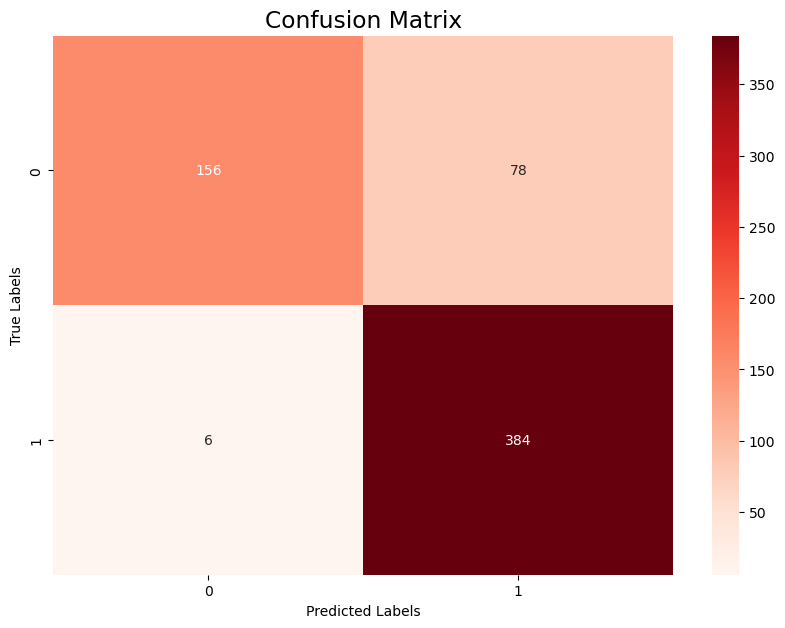

In [43]:
labels = []

for _, label_batch in test:
    # This flattens the batch and appends individual labels
    labels.extend(label_batch.numpy())

# Now, 'labels' is a flat list containing all labels
y_true = np.array(labels)

y_pred = resnet.predict(test)
y_pred = np.argmax(y_pred, axis=1)

y_pred.shape, y_true.shape

cm = tf.math.confusion_matrix(y_true, y_pred)
# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
sns.set(font_scale=1.4)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

To see what is our recal, precision and f1:

In [44]:
# Flatten matrix
tn, fp, fn, tp = cm.numpy().ravel()

# Calculate values
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

# Print
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8312
Recall: 0.9846
F1 Score: 0.9014


The model has a bias towards classifying patients with pneumonia when there atcually don't have it. This is because of the imbalance of the training dataset. I have trained a second model with balanced number of samples (1341 samples for normal and pnuemonia). Here it is:

In [45]:
resnet_balanced = tf.keras.saving.load_model('../content/models/ResNet151V2_GRADCAM_BALANCED/ResNet151V2_v1_GRADCAM_BALANCED_v0.keras') # Around 2m to load

In [46]:
resnet_balanced.evaluate(validation)

2024-02-09 07:59:42.363675: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


17/17 [==============================] - 8s 250ms/step - loss: 0.1630 - accuracy: 0.9501


[0.16299307346343994, 0.9500959515571594]

In [47]:
resnet_balanced.evaluate(test)

20/20 [==============================] - 3s 172ms/step - loss: 0.2844 - accuracy: 0.9199


[0.2843758165836334, 0.9198718070983887]

Learning rate and accuracy plots via tensorbard. Validation (purple), train (blue):

<img src="./images/gr.png" style="height:300px" />

<img src="./images/gr2.png" style="height:300px" />

Here we can see the logs.

`--bind_all` makes sure that it listens to all IPs since I am running TF on wsl:

In [48]:
%load_ext tensorboard

In [49]:
%tensorboard --bind_all --logdir /home/tf/prj/content/logs

The model trained on balanced data has 0.92 test accuracy as well as val accuracy of  0.95. This doesn't mean that the model is ready for the real world since it basically only knows 2 conditions: sick and not sick. A more robust model needs to have a corpus of different diseases. More on that later. Here is a cm:

20/20 [==============================] - 60s 3s/step


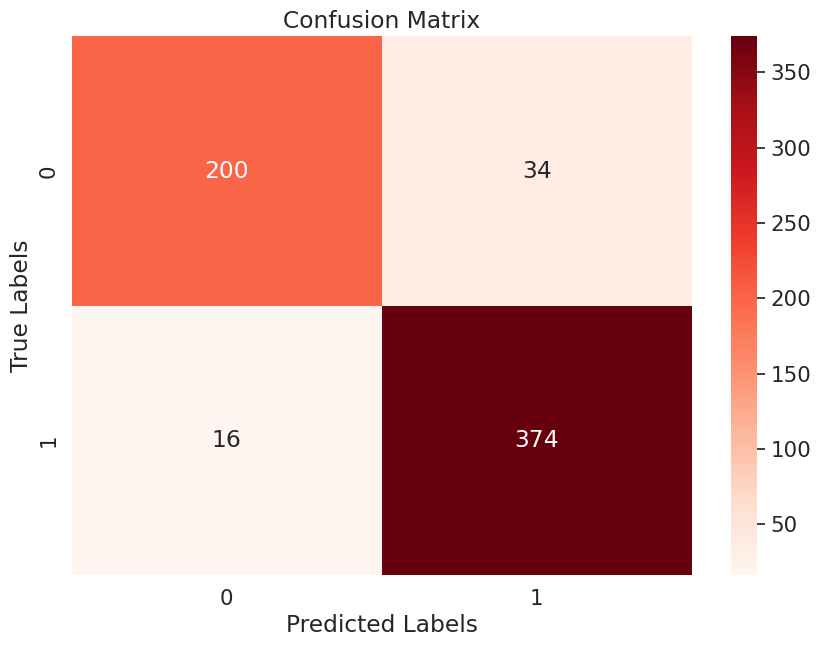

In [50]:
labels = []

for _, label_batch in test:
    # This flattens the batch and appends individual labels
    labels.extend(label_batch.numpy())

# Now, 'labels' is a flat list containing all labels
y_true = np.array(labels)

y_pred = resnet_balanced.predict(test)
y_pred = np.argmax(y_pred, axis=1)

y_pred.shape, y_true.shape

cm = tf.math.confusion_matrix(y_true, y_pred)
# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
sns.set(font_scale=1.4)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
# Flatten matrix
tn, fp, fn, tp = cm.numpy().ravel()

# Calculate values
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

# Print
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9167
Recall: 0.9590
F1 Score: 0.9373


As we see precision, recall and f1 got bumped up by a few points. The cm also shows better accuracy and is not so much skewed towards classifying healthy people with pneumonia. More data for the model is in `/logs`.

#### Visualizations and explainability

When trying to understand a DL model there are generally two routes: post-hoc methods and intrinsic ones. Post-hoc methods implement techniques *after* a model has been trained while intrinsic methods are generally techniques that give intrinsic explainability and algorithmic transparency.

I will now implement two post-hoc methods for model explainability. GradCam and a segmentation algrorithm using Lime.

> I have also tried SHAP but I had OOM errors which was weird and I couldn't get it resolved. So I guess I was *SHAP-ed* through the heart :')

First I will make sure to set my model as to not be trainable:

In [52]:
resnet_balanced.trainable = False

In [53]:
def get_rand_img(main_dir, class_dir):
    working_dir = f'{main_dir}' + f'{class_dir}'
    dir_len = len(os.listdir(working_dir))
    random_image = os.listdir(working_dir)[np.random.randint(0, dir_len)]
    image_path = os.path.join(working_dir, random_image)
    return image_path

In [54]:
dir_class = 'PNEUMONIA'
main_dir = '../data/chest_xray/test/'
image_path = get_rand_img(main_dir, dir_class)

#### Lime:
Local Interpretable Model-agnostic Explanations (LIME) is a method for understanding models after being trained. To explain how it works let's imagine that we have a tiny little gnome 🧙‍♂️ in a box 📦. 

The gnome is our model and we cannot access the box directly, we can only probe it by putting pictures and getting the gnome's (the model's) predictions in the form of drawn circles (these are the weights). We then change slightly some aspects of the picture, like moving pixels, changes in gamma and so on and we give it back to the gnome in the box. He then gives us the second prediction and we look if he has changed his opinion and position of the drawn classification circles. We can compute generally which points have higher confidence and a lower one. We then create a linear model that has been trained to learn the predictions of the model. It is importnat to mention that we examine only a part of the model - sorry gnome-y, we chopped you :( 

The simpler model learns pretty well the local *predictions*, but it is useless in the big picture, but that's his purpose, so let's not give him anxiety.

Explaining it mathematically is a little bit harder. If we have an $\text{explanation}(x)$, where $x$ is an instance/data point in a model's specific layer (no more gnomes, I promise) [the original paper's authors](https://arxiv.org/pdf/1602.04938.pdf) define the function as:

$$\text{explanation}(x) = \underset{g \in G}{\arg\min} \; L(f, g, \pi_x) + \Omega(g)$$

Where we minimize the loss $L$ while keeping model's complexity $\Omega(g)$ low. $g$ is denoted as the model and $f$ is the prediction. $G$ is a set of all possible linear algorithms and $\pi_{x}$ is the radius of the data point $x$ in which a new data points (from the simpler model) are considered explanations. Simple right? Ok now you deserve a treat, here's a pun:  

*The gnome flunked his spelling test because he forgot it was Friday. If only he’d Gnome!* 

I lied for the gnomes muahuahdua!

#### Code implementation:

My implementation of Lime is to first load a specific image, give it to the trained and the new model and plot the segmentations:

In [55]:
def preprocess_image(img_path, target_size=(224, 224)):
    # Take a raw img, load it as a tensor and preprocess it
    img = tf_image.load_img(img_path, target_size=target_size)
    img = tf_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)  
    return img

# Original repo with Lime tutorials can be found @:
# https://github.com/marcotcr/lime?tab=readme-ov-file 
def plot_lime(img_path, model):
    print(f'Processing {img_path}')
    # Explain a prediction
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1) # I chose 'slic' cause of this:
                                                                                      # https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Faces%20and%20GradBoost.ipynb

    img = preprocess_image(img_path)[0]  # Preprocess the image

    # Make predictions
    preds = model.predict(img[np.newaxis, ...])  # Add batch dimension
    top_pred_index = np.argmax(preds[0])  # Index of the top prediction
    top_pred_label = ['NORMAL', 'PNEUMONIA'][top_pred_index]  # Labels are hard coded, because life is also hard
    top_pred_prob = preds[0][top_pred_index]  # Probability of top prediction

    # Get the explanation
    explanation = explainer.explain_instance(img.astype('double'), 
                                            classifier_fn=model.predict, 
                                            top_labels=2, 
                                            hide_color=0, 
                                            num_samples=1000, 
                                            segmentation_fn=segmenter,
                                            # progress_bar=False
                                            )

    # Display the top label's explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()

    print(f"Model's predicted class: {top_pred_label} with probability {top_pred_prob}")


Plot resuts:

Processing ../data/chest_xray/test/PNEUMONIA/person113_bacteria_540.jpeg
1/1 [==============================] - 8s 8s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 16s 16s/step


  1%|          | 10/1000 [00:15<26:18,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 20/1000 [00:17<11:58,  1.36it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 30/1000 [00:18<07:24,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 40/1000 [00:19<05:14,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 50/1000 [00:21<04:02,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 60/1000 [00:22<03:20,  4.70it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:23<02:50,  5.45it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 80/1000 [00:24<02:33,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 90/1000 [00:26<02:21,  6.43it/s]

1/1 [==============================] - 0s 74ms/step


 10%|█         | 100/1000 [00:27<02:13,  6.75it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 110/1000 [00:28<02:06,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 120/1000 [00:30<02:00,  7.30it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 130/1000 [00:31<01:56,  7.45it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:32<01:53,  7.58it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 150/1000 [00:33<01:52,  7.56it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 160/1000 [00:35<01:49,  7.69it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 170/1000 [00:36<01:48,  7.68it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 180/1000 [00:37<01:46,  7.72it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 190/1000 [00:39<01:44,  7.74it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 200/1000 [00:40<01:42,  7.82it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 210/1000 [00:41<01:40,  7.90it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 220/1000 [00:42<01:38,  7.90it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 230/1000 [00:44<01:37,  7.93it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 240/1000 [00:45<01:35,  7.95it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 250/1000 [00:46<01:33,  8.03it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 260/1000 [00:47<01:33,  7.92it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 270/1000 [00:49<01:31,  8.01it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 280/1000 [00:50<01:30,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 290/1000 [00:51<01:28,  7.99it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 300/1000 [00:52<01:28,  7.92it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 310/1000 [00:54<01:27,  7.89it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 320/1000 [00:55<01:25,  7.92it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 330/1000 [00:56<01:25,  7.85it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 340/1000 [00:57<01:23,  7.90it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 350/1000 [00:59<01:21,  7.98it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 360/1000 [01:00<01:21,  7.89it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 370/1000 [01:01<01:20,  7.84it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 380/1000 [01:03<01:19,  7.83it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 390/1000 [01:04<01:18,  7.82it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 400/1000 [01:05<01:15,  7.90it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 410/1000 [01:06<01:14,  7.93it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 420/1000 [01:08<01:13,  7.86it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 430/1000 [01:09<01:12,  7.87it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 440/1000 [01:10<01:10,  7.93it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 450/1000 [01:11<01:08,  7.99it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 460/1000 [01:13<01:08,  7.90it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 470/1000 [01:14<01:07,  7.83it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 480/1000 [01:15<01:05,  7.91it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 490/1000 [01:17<01:05,  7.82it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 500/1000 [01:18<01:03,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 510/1000 [01:19<01:02,  7.90it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 520/1000 [01:20<01:00,  7.96it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 530/1000 [01:22<00:59,  7.87it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 540/1000 [01:23<00:57,  7.94it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 550/1000 [01:24<00:56,  7.90it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 560/1000 [01:25<00:55,  7.94it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 570/1000 [01:27<00:54,  7.92it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 580/1000 [01:28<00:53,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 590/1000 [01:29<00:52,  7.87it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 600/1000 [01:30<00:51,  7.82it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 610/1000 [01:32<00:49,  7.86it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 620/1000 [01:33<00:48,  7.89it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 630/1000 [01:34<00:46,  7.92it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 640/1000 [01:35<00:45,  7.92it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 650/1000 [01:37<00:44,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 660/1000 [01:38<00:43,  7.82it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 670/1000 [01:39<00:42,  7.85it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 680/1000 [01:41<00:40,  7.83it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 690/1000 [01:42<00:39,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 700/1000 [01:43<00:37,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 710/1000 [01:44<00:36,  7.92it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 720/1000 [01:46<00:36,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 730/1000 [01:47<00:38,  7.00it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 740/1000 [01:49<00:38,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 750/1000 [01:50<00:35,  7.12it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 760/1000 [01:52<00:33,  7.15it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 770/1000 [01:53<00:31,  7.36it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 780/1000 [01:54<00:28,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 790/1000 [01:55<00:27,  7.69it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 800/1000 [01:57<00:25,  7.81it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 810/1000 [01:58<00:24,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 820/1000 [01:59<00:23,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 830/1000 [02:04<00:40,  4.22it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 840/1000 [02:05<00:29,  5.41it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 850/1000 [02:06<00:24,  6.13it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 860/1000 [02:07<00:20,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 870/1000 [02:08<00:15,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 880/1000 [02:08<00:12,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 890/1000 [02:09<00:10, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 900/1000 [02:10<00:10,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 910/1000 [02:12<00:10,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 920/1000 [02:13<00:09,  8.18it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 930/1000 [02:14<00:08,  8.26it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 940/1000 [02:15<00:07,  8.36it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 950/1000 [02:17<00:05,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 960/1000 [02:18<00:04,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 970/1000 [02:19<00:03,  8.89it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 980/1000 [02:20<00:02,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 990/1000 [02:21<00:01,  8.90it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


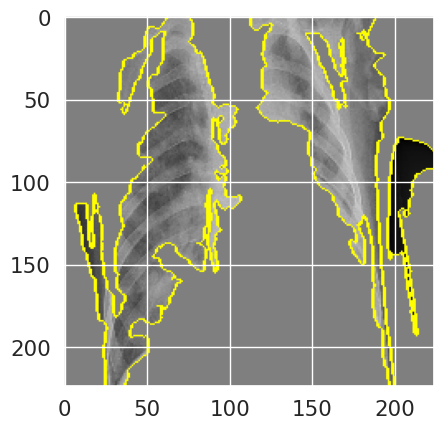

Model's predicted class: PNEUMONIA with probability 0.9999644756317139


In [56]:
plot_lime(image_path, resnet_balanced)

> For some reason `progress_bar = False` in `explainer.explain_instance()` does not work and it plots a long progress bar. I even opened an [issue](https://github.com/marcotcr/lime/issues/739#issue-2124913438) on the main github repo.

As you can see the segmentation shows that the area around the lungs is important for model prediction. This is also pretty logical. 

### GradCam:

Ok now to understand how this works imagine that there is a red dragon 🐲 and...

Alright, alright. I am gonna stop. Here is the real thing:

Gradient-weighted Class Activation Mapping (Grad-CAM), first proposed by [Ramprasaath R. Selvaraju et al.](https://arxiv.org/abs/1610.02391), is a post-hoc technique of explaining how a model sees images. Essentially this is a method for visualizing which parts of an image are important for a convolutional neural network's decision.

The technique works by first focusing on a certain layer of the model (usually the *last* one, but there are variations). Grad-CAM then computes the gradients flowing through the layer and creates a heatmap by taking the weighted values of the gradients. We then add a ReLu function so to get only the positive values since
$\text{ReLU}(x) = 
\begin{cases} 
0 & \text{if } x < 0 \\
x & \text{if } x \geq 0 
\end{cases}
$.

Here is my implementation:

In [57]:
def calculate_grad_cam(image_path, model, model_preprocess_func, last_conv_layer_name = None, output_classification_layers = None, target_size=(224, 224, 3)):
    # Load original image
    original_image = tf_image.load_img(image_path, target_size=target_size)
    image = np.array(original_image)
    image = tf.keras.applications.resnet_v2.preprocess_input(image.copy().astype(np.float32))

    # Take the last conv layer of the model
    if last_conv_layer_name is None:
        layer_conv = 'conv5_block3_out'
    else:
        layer_conv = last_conv_layer_name 

    # Create a new model with the old input and as output use layer_conv
    last_conv_layer = model.get_layer(layer_conv)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Get last conv layer output shape and save it to x
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    # Pass the classification head of the model that has been passed to the function to the new model
    if output_classification_layers is None:
        for layer_name in ["post_bn", "post_relu", "global_average_pooling2d", "dense", "dropout", "dense_1"]: # This essentially takes all of the top head and puts it onto the new model
            x = model.get_layer(layer_name)(x)                                                                 # there are better ways to do that. Don't judge me pls :)
    else:
        for layer_name in output_classification_layers:
            x = model.get_layer(layer_name)(x)

    # Set the new model
    classifier_model = tf.keras.Model(classifier_input, x)

    # Calculate gradient of the last conv layer
    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...] # Expand image axis
        last_conv_layer_output = last_conv_layer_model(inputs) # Get last_conv_layer_model output values
        tape.watch(last_conv_layer_output) 
        preds = classifier_model(last_conv_layer_output) # Make predictions based on the last conv layer
        top_pred_index = tf.argmax(preds[0]) # Get the bestt prediction, i.e. pneumonia or normal
        top_class_channel = preds[:, top_pred_index] # Take output with prediction of the top class 
    
    grads = tape.gradient(top_class_channel, last_conv_layer_output) # Compute gradients of top_class_channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # Average the result

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam))


    gradcam = cv2.resize(gradcam, (224, 224))

    return gradcam

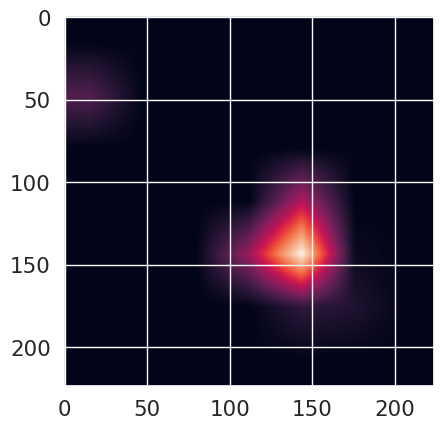

In [58]:
model_preprocess_func = tf.keras.applications.resnet_v2.preprocess_input
grad_cam = calculate_grad_cam(image_path=image_path, model=resnet_balanced, model_preprocess_func = model_preprocess_func)
plt.imshow(grad_cam)

That's a nice blob. But let's superimpose it to the original:

In [59]:
def plot_grad_cam(gradcam, image_path, target_size=(224, 224), model = None):
    # Load the original image
    original_image = tf_image.load_img(image_path, target_size=target_size)
    image = np.array(original_image)

    # Convert GRAD-CAM heatmap to RGB
    gradcam = gradcam / gradcam.max()  # Normalize
    heatmap = np.uint8(255 * gradcam)  # Convert to uint8 because matplotlib needs it
    heatmap = plt.get_cmap('hot')(heatmap)[:, :, :3]  # Give the image some color
    heatmap = np.uint8(255 * heatmap)  # Scale to 0, 255
    superimposed_image = heatmap * 0.7 + image  # Superimpose the heatmap on original with weighted addition

    # Display the original and superimposed image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(original_image)  # Show original image without preprocessing

    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.imshow(superimposed_image.astype(np.uint8))  # Convert superimposed image to uint8 to display

    plt.show()

    # Make predictions
    predicted_image = tf.keras.applications.resnet_v2.preprocess_input(image) # Get prediction
    preds = model.predict(predicted_image[np.newaxis, ...])  # Add batch dimension
    top_pred_index = np.argmax(preds[0])  # Index of the top prediction
    top_pred_label = ['NORMAL', 'PNEUMONIA'][top_pred_index]  # Labels are hard coded, because life is also hard
    top_pred_prob = preds[0][top_pred_index]  # Probability of top prediction

    print(f"Model's predicted class: {top_pred_label} with probability {top_pred_prob}")

Plot resuts:

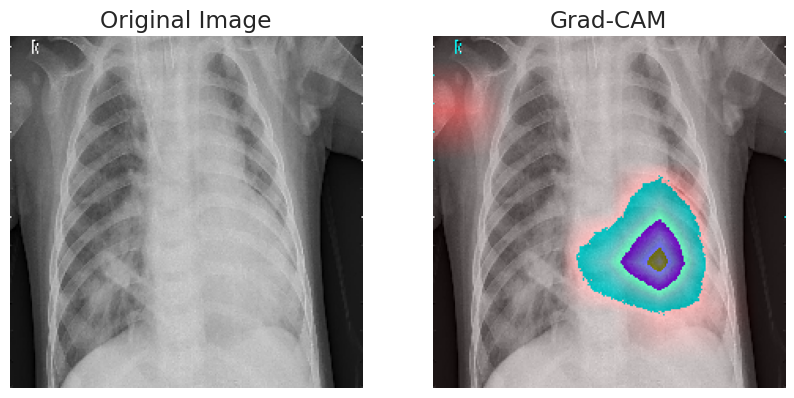

1/1 [==============================] - 0s 35ms/step
Model's predicted class: PNEUMONIA with probability 0.9999644756317139


In [60]:
plot_grad_cam(gradcam = grad_cam, image_path = image_path, model = resnet_balanced)

It seems like the model focuses somewhat on the centre-right of the image. Let's see more examples.

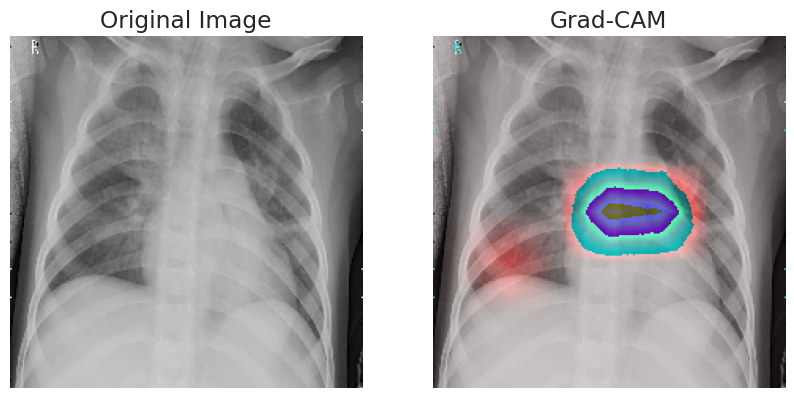

1/1 [==============================] - 0s 51ms/step
Model's predicted class: PNEUMONIA with probability 0.977593183517456


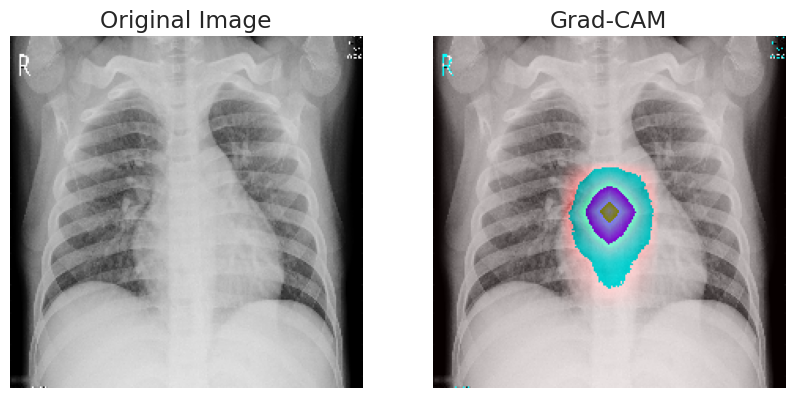

1/1 [==============================] - 0s 29ms/step
Model's predicted class: NORMAL with probability 0.9013599157333374


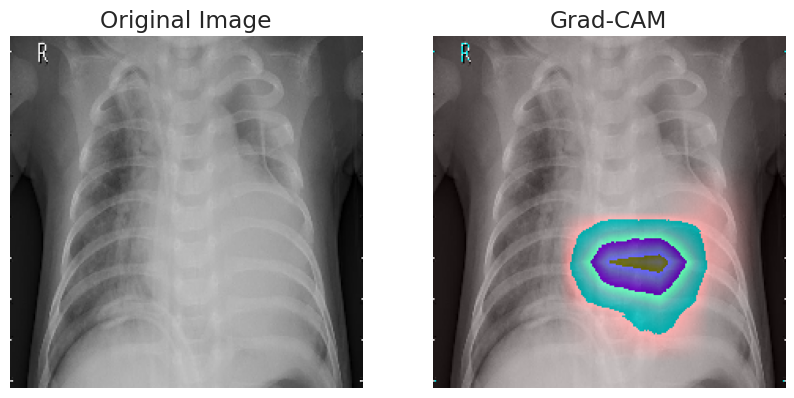

1/1 [==============================] - 0s 36ms/step
Model's predicted class: PNEUMONIA with probability 0.9999741315841675


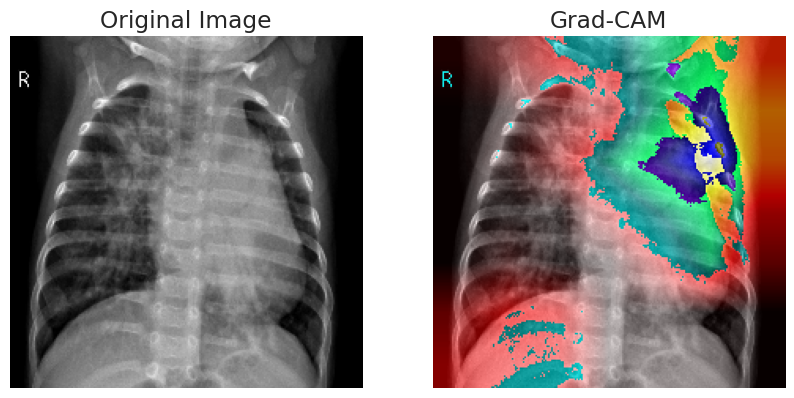

1/1 [==============================] - 0s 40ms/step
Model's predicted class: NORMAL with probability 0.7190965414047241


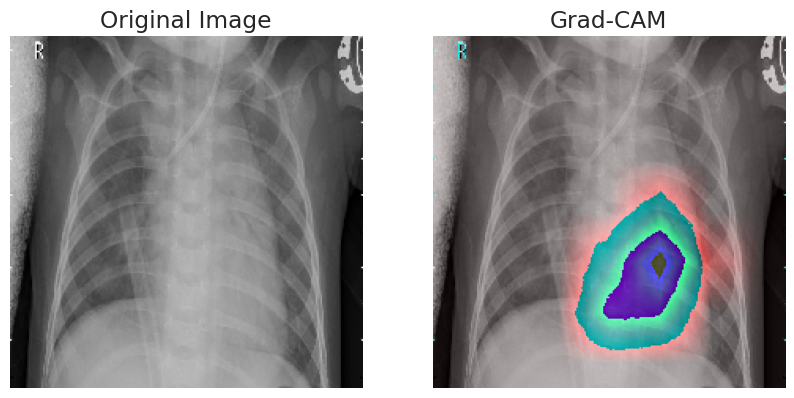

1/1 [==============================] - 0s 31ms/step
Model's predicted class: PNEUMONIA with probability 0.9999953508377075


In [62]:
dir_class = 'PNEUMONIA'
main_dir = '../data/chest_xray/test/'
imgs = []
for _ in range(5):
    imgs.append(get_rand_img(main_dir, dir_class))

for image in imgs:
    model_preprocess_func = tf.keras.applications.resnet_v2.preprocess_input
    grad_cam = calculate_grad_cam(image_path=image, model=resnet_balanced, model_preprocess_func = model_preprocess_func)
    plot_grad_cam(gradcam = grad_cam, image_path = image, model = resnet_balanced)

Yup, it is consistent. Trying with the train dataset will give the same results (I have tried it). Crossvalidatiing the results with other projects on the same data set show similar resuts:


<img src="../main/images/results.png" style="height:500px" />

*Source - [link](https://www.kaggle.com/code/tavetisyan/x-ray-pneumonia-detection-97-test-accuracy)*

During these visualizations it is essential for understanding a model deeply, because it is not sensible to put an algorithm on your platform that controls a lot of things (like a recommendation system) and *not* know how and what the algorithm has learned. What if he promotes only videos of brown ducks or gnomes? 

Even more serious are the implications in medical imaging. It is possible for a model to learn elements of the image that are fragments like letters "R" and "L" which are often there to show the position of the patient in the photo. Or other text that essentially gives the prognosis away.

I am glad that my model doesn't do these things and I imagine that XAI will be become more and more important as more companies want to implement it.

### 4. Discussion

Although the model has satisfying results, it is not at all ready for the real world environment. A model that knows that there are only healthy and pneumonia-sick patients will classify everything as one or the other. This means that people with different conditions will be misclassified. This is why we need to train a model on more data with more classes. The mentioned NIH Chest X-ray dataset has a bunch of classes and subclasses. Many people have tried to train models on them with above average results - there is still a room for improvement. The works I have found on this problem are of course the mentioned CheXNet and NIH-Chest-X-rays-Classification project on GitHub. Here are their results:


<img src="https://github.com/paloukari/NIH-Chest-X-rays-Classification/raw/master/images/ensemble_results_table.png" style="height:300px" />

*Table 1. Results from NIH-Chest-X-rays-Classification project on GitHub*

<img src="https://github.com/paloukari/NIH-Chest-X-rays-Classification/raw/master/images/table%20of%20architecture%20results.png" style="height:350px" />

*Table 2. Results for different base models. Source is the  IH-Chest-X-rays-Classification project on GitHub*

<img src="../main/images/tbl3.png" style="height:300px" />

*Table 3. Results from CheXNet. [Source](https://arxiv.org/pdf/1711.05225.pdf) (table 2. of the original paper)*

As one can see the results in tables 1. and 3. aren't that different and the results are optimal but still more to be desired (Infiltration for example has scores of 0.73 with ChexNet and 0.68 with the ensemble models).

##### Now I want to explain my view of this problem:
The mentioned approaches to this problem are essentially building one or a couple networks, voting on the network's results if we are in the second scenario, and outputting a prediction. The first approach isn't that great if we consider some facts about the domain - many of the medical conditions correlate to each other, some are really different, some are not. For example consolidation, effusion and pulmonary infiltration all are conditions where liquid is somewhere that is not supposed to be (lungs, alveoli, between the lungs and the chest cavity); mass and nodules are almost the same thing, but a mass is bigger and bumpy; cardiomegaly is abnormal heart size and so on.

These conditions have different symptoms and generally a doctor can start examining based on those symptoms as well as checking patient's history. The doctor doesn't really check for every single condition, but the proposed models do (at least for those that they have learned) - this doesn't really reflect how humans do it (not that this is always an optimal metric, just in this case) and it will be not computationally efficient to train a single model for **every** type of condition. In essence it looks like the mentioned researchers try to make a **general x-ray model**, but building such thing presumably requires a more advanced architecture.

The second approach, specifically the NIH-Chest-X-rays-Classification project is on the right track, where 3 networks with different ensemble voting techniques make a prediction.

Another approach to this problem will be to have $n$ number of neural nets that are trained on a set of conditions, and a second net(s) that choose(s) the right one for the task. I am talking about MoE of course.

The protocol of a MoE is simple. Train $n$ number of models (experts) on a given task, train a second model(s) (called a router) that learns which models to choose for the specific job and lastly, weight the output of every expert and make a prediction. This method resembles much more the real life process where a doctor first examines a patient, then, by observing and taking some data, he takes a **direction towards** prediction which incorporates different methods (and even skills and parts of the brain if we want to get really deep into it), much like a router does.

Current models that use MoE architecture are directed towards creating LLMs and using MoEs for classification isn't really popular, after all we already have thousands of image classifiers, and a [thousand](https://huggingface.co/models?pipeline_tag=object-detection&sort=trending) algorithms for object detection and image segmentation (e. g. YOLO). These models can capture live feed and classify and/or segment objects and images in real time in a 3D space. Why introduce MoEs to the picture?

There a two main reasons. First is that MoEs for medical imaging hasn't been really implemented and to best of my knowledge there aren't any papers on this subject. At least trying to create such an implementation will give us a little bit more insight to the task at hand. 

Except the novelty, MoE models have a couple of advantages such as improved generalization and computational efficiency. 

I have tried implementing a MoE of classifying the NIH crx8 (Chest X-ray 8) dataset but to no avail. For once, I didn't have time (writing this on 07-02-2024) to make it work, which one can take it as an excuse. I take it as a failure. Main reason is that I couldn't really get the router to work properly. My approach was to have $n$ number of models with a similar architecture to that of the resnet model. I also had problem finding research on that task.

The results I got from trying to create such a model are in `/logs/` and can be seen in my kaggle draft notebook. In short the results I got were pretty bad:

Learning rate and accuracy plots via tensorbard. Validation (grey), train (green):

<img src="./images/gr3.png" style="height:300px" />

<img src="./images/gr4.png" style="height:300px" />

Since I haven't shown my model (because there really isn't that much to show, that's why I am leaving it in the draft which I have already linked) commenting the results won't do much. I would really like to explore more on this topic since the novelty is pretty interesting.

All in all I have manged to train a simple model with transfer learning for pneumonia detection that cannot really be used in the real world because of the inherent bias (trained only on pneumonia samples). New methods can be probably be used for achieving greater results.

This whole project was really interesting for me, because I felt the whole process of where I started with a simple idea, met and experienced challenges and then tried to understand and document them. It really felt like a journey.

## 5. Sources:

1. TensorFlow Tutorials - Data Augmentation - [link](https://www.tensorflow.org/tutorials/images/data_augmentation)
1. TensorFlow API Docs - DirectoryIterator - [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator)
1. TensorFlow Tutorials - Load Images - [link](https://www.tensorflow.org/tutorials/load_data/images)
1. TensorFlow API Docs - image_dataset_from_directory - [link](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
1. TensorFlow API Docs - ImageDataGenerator - [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
1. TensorFlow Tutorials - Image Data Augmentation - [link](https://www.tensorflow.org/tutorials/images/data_augmentation)
1. TensorFlow Tutorials - Image Classification - [link](https://www.tensorflow.org/tutorials/images/classification)
1. NIH Chest X-ray Dataset - [link](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/219760887468)
1. Hugging Face Datasets - NIH Chest X-ray - [link](https://huggingface.co/datasets/alkzar90/NIH-Chest-X-ray-dataset)
1. Research Paper: ChestX-ray8 - [link](https://arxiv.org/pdf/1711.05225.pdf)
1. Medium Article: Effect of Batch Size on Training Dynamics - [link](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e)
1. AI Stack Exchange: High Validation/Test Accuracy - [link](https://ai.stackexchange.com/questions/18397/why-is-my-validation-test-accuracy-higher-than-my-training-accuracy)
1. Netron - [link](https://netron.app/)
1. Stack Overflow: Loss Decreasing but Accuracy Stable - [link](https://stackoverflow.com/questions/43499199/tensorflow-loss-decreasing-but-accuracy-stable)
1. Hugging Face Blog: Mixture of Experts - [link](https://huggingface.co/blog/moe)
1. Keras Examples: Grad-CAM - [link](https://keras.io/examples/vision/grad_cam/)
1. Towards Data Science: Understanding Grad-CAM - [link](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353)
1. TensorFlow Tutorials: Integrated Gradients - [link](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?authuser=4#next_steps)
1. Google Cloud Training: Integrated Gradients Notebook - [link](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/blogs/integrated_gradients/integrated_gradients.ipynb)
1. GitHub: Grad-CAM TensorFlow 2 Notebook - [link](https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb)
1. GitHub: LIME Image Classification Keras Notebook - [link](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb)
1. GitHub SHAP Issue: SHAP with Image Data - [link](https://github.com/shap/shap/issues/1761)
1. JMLR: TELL - A Tensor Linguistic Representation for Machine Learning - [link](https://github.com/XLearning-SCU/2022-JMLR-TELL)
1. JMLR Paper: TELL - [link](https://www.jmlr.org/papers/v23/19-497.html)
1. JMLR Paper PDF: TELL - [link](https://www.jmlr.org/papers/volume23/19-497/19-497.pdf)
1. HELDA: Research Repository - [link](https://helda.helsinki.fi/server/api/core/bitstreams/bbc0e7e3-52fa-4a9c-9552-47ae40e014f2/content)
1. ForSight AI - [link](https://www.forsight.ai/)
1. Copyleaks AI Content Detector - [link](https://copyleaks.com/ai-content-detector)

***

<div style="text-align: center;">
    <img src="./images/12612032.png" style="height:300px" />
</div>